In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
conn = sqlite3.connect('../dataset/checking-logs.sqlite')
conn

<h2>Создание таблицы с количеством коммитов</h2>

In [3]:
query = """
SELECT 
    uid, COUNT (*) AS num_commits
FROM
    checker
WHERE 
    uid LIKE 'user_%'
AND 
    labname <> 'project1'
GROUP BY uid
"""

commits = pd.io.sql.read_sql(query, conn)
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


<h2>Создание таблицы с количеством просмотров</h2>

In [4]:
query = """
SELECT
    uid, COUNT (*) AS pageviews
FROM 
    pageviews
WHERE
    uid LIKE 'user_%'
GROUP BY uid
"""

pageviews = pd.io.sql.read_sql(query, conn)
pageviews

,uid,pageviews
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


<h2>Создание таблицы с DELTA, разница между первым коммитом и дедлайном лаборатории(Day 06 ex03) Не учитывать project1</h2>

In [5]:
query = '''
SELECT uid,
       CAST((JulianDay(test.first_commit_ts) -
            JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))
                  ) * 24 AS Integer
           ) AS avg_diff
FROM test
LEFT JOIN deadlines ON test.labname=deadlines.labs
WHERE labname <> 'project1'
'''
avg_diff = pd.io.sql.read_sql(query, conn)
avg_diff

,uid,avg_diff
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


<h2>Объединим и выведем DELTA по каждому пользователю</h2>

In [6]:
avg_diff = avg_diff.groupby(['uid']).mean()
avg_diff

,avg_diff
uid,
user_1,-64.400000
user_10,-74.800000
user_14,-159.000000
user_17,-61.600000
user_18,-5.666667
user_19,-98.750000
user_21,-95.500000
user_25,-92.600000
user_28,-86.400000


<h2>Создайте таблицу, в которой для каждого пользователя из тестовой группы будет указана средняя разница, количество просмотров страниц и количество коммитов</h2>

In [7]:
pivot_table = pageviews.merge(commits, on=['uid'])
pivot_table = avg_diff.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = 'uid')
pivot_table

,avg_diff,pageviews,num_commits
0,-64.400000,28,62
1,-74.800000,89,20
2,-159.000000,143,61
3,-61.600000,47,51
4,-5.666667,3,5
5,-98.750000,16,118
6,-95.500000,10,65
7,-92.600000,179,79
8,-86.400000,149,60
9,-105.400000,317,18


<h2>KDE (Kernel Density Estimation) – это метод оценки плотности вероятности случайной величины без предположений о виде этой плотности. Проще говоря, он помогает визуализировать распределение значений переменных, показывая, где значения встречаются чаще всего.</h2>
Красные точки на графике представляют данные, которые имеют положительную корреляцию друг с другом. Это означает, что когда значение одной переменной увеличивается, значение другой переменной также имеет тенденцию увеличиваться. Голубые линии на графике, напротив, показывают данные, которые имеют отрицательную корреляцию друг с другом. Это значит, что когда значение одной переменной увеличивается, значение другой переменной обычно уменьшается.

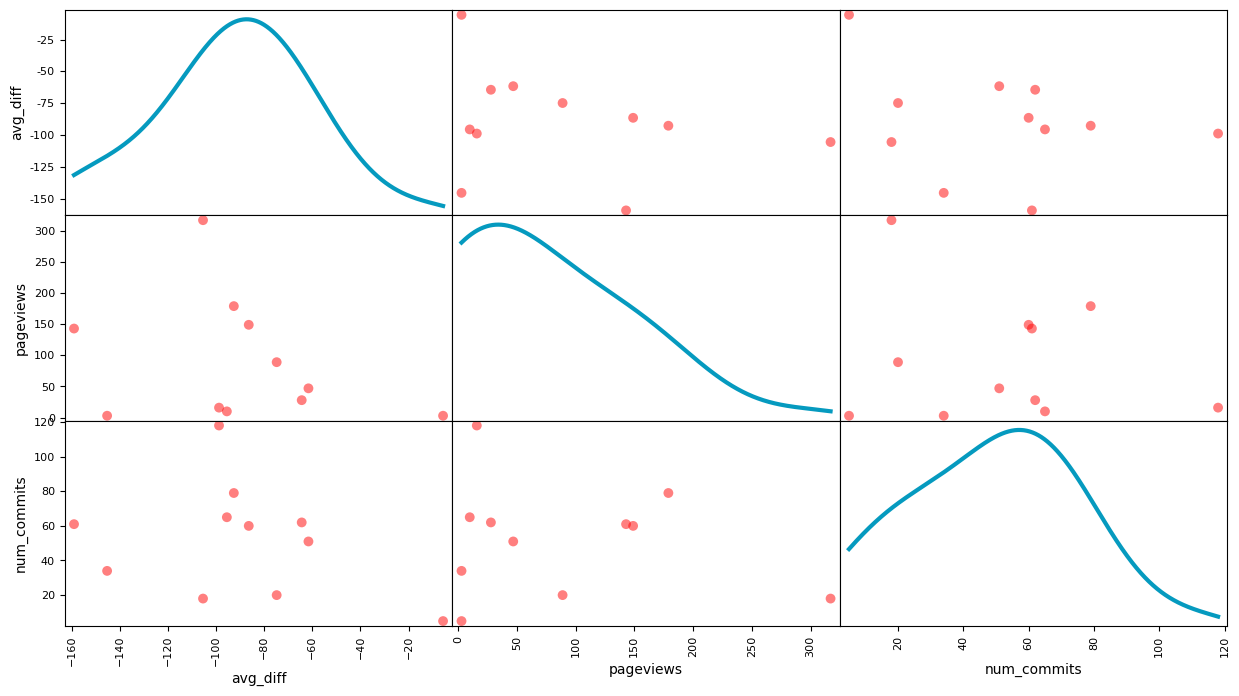

In [8]:
ax = scatter_matrix(pivot_table,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#059ABF', linewidth=3),
                    s=200,
                    color='red')

In [9]:
conn.close()

<h2>«Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него мало коммитов?» Ответ: да или нет.</h2>

нет, потому что на графике видно, что пользователи которые посещали мало страниц, оставляли иногда даже большее количество коммитов, чем пользователи с большей активностью посещения страниц

<h2>«Можно ли сказать, что если у пользователя мало просмотров страниц, то, скорее всего, у него небольшая средняя разница между первым коммитом и крайним сроком выполнения лабораторной работы?» Ответ: да или нет.</h2>

Нет

<h2>«Можно ли сказать, что есть много пользователей с небольшим количеством коммитов и несколько пользователей с большим количеством коммитов»? Ответ: да или нет.</h2>

Да

<h2>«Можно ли сказать, что есть много пользователей с небольшой средней разницей и несколько пользователей с большой средней разницей»? Ответ: да или нет.</h2>

Да